In [1]:
from google.colab import drive
import os
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [13]:
#put your own keys
#wandbkey=''
#hf_key=''
#openai_key=''

In [ ]:
!pip install evaluate
!pip install bert_score
!pip install wandb
!pip install -U datasets
!pip install -q loralib sentencepiece
!pip uninstall transformers
!pip -q install git+https://github.com/huggingface/transformers # need to install from github
!pip -q install git+https://github.com/huggingface/peft.git
!pip -q install bitsandbytes
!pip install openai
!MAX_JOBS=6 pip install flash-attn --no-build-isolation --upgrade
!pip install git+https://github.com/huggingface/trl.git
!pip -q install git+https://github.com/huggingface/accelerate
!pip install --no-deps xformers

In [5]:
import wandb
wandb.login(key=wandbkey)
from huggingface_hub import notebook_login
notebook_login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
from   transformers import BitsAndBytesConfig, TrainingArguments, Trainer,pipeline,AutoTokenizer,AutoModelForCausalLM
from   trl      import SFTTrainer,SFTConfig
from datasets import load_dataset,features
import torch
import random
from   peft     import prepare_model_for_kbit_training, LoraConfig, get_peft_model,PeftModel, PeftConfig
import pandas   as     pd
import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use('ggplot')
%matplotlib inline

PLAN:

1. we will work with a small model to check the concept/idea
2. Data set organization: we will start by examining the success level on a small part of the dataset. Based on it , we can finetune hyperparams, examine modification or larger models if needed.
3. There are various approaches possible and continuos training schemes,sush as:
- faster training with unsloth.
- multi-gpu training with deepspeed/fsdp for memory efficiency (but this model is actually small , so no need in sophisticaitons)
- Train with DPO/SimPO (or other valid RLHF scheme) after finetuning on the initial portion ,checking the results if ok continue to improve etc.

4. The training will be logged to wandb , hope you have an account, cause you'll be able to reproduce the training and monitor loss, gpu usage , learning rate etc.

However we will go with the basic scheme of SFT (supervised finetuning) + PEFT(LORA) - since we're quite sure that the given model is already trained and adapted to hte given language capabilities.
For better performance we will use flash attention 2.

Dataset praparation:
 - train/validation/test splits
 - we would like to limit set the ptraining parameter: max_sequence_length to 512 tokens -> we need to filter our samples so to be of lengths ~2k characters.
 - I've made a test where the used data collator was set to  DataCollatorForCompletionOnlyLM,  (practically the loss function was calculated only on the generated text) , as a comparison with learning from the entire sequence,  I didn't notice any improvement on the measured metrics. Also , calculating the loss from the entire sequence, we finetune the model to better understand the communication in given style.

In [3]:
#take initial dataset portion
tr_dataset = load_dataset("rajpurkar/squad", split="train")
tr_dataset = tr_dataset.shuffle(seed=42)
tr_dataset = tr_dataset.remove_columns(['id', 'title'])
ds_train_devtest = tr_dataset.train_test_split(test_size=0.8, seed=42)
ds_train_devtest=ds_train_devtest['train'].train_test_split(test_size=0.03, seed=42)
test = load_dataset("rajpurkar/squad", split="validation[:1%]")
test_dataset = test.remove_columns(['id', 'title'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
#apply needed chat format and organize the dataset
def convert_squad_sample_to_llama_conversation(sample):
    question = sample['question']
    context = sample['context']
    answers = sample['answers']['text']
    if len(answers) == 0 :
      answer = "The context does not provide an answer..."
    else:
      answer = sample['answers']['text'][0]
    instruction_prompt_template = """
    You are a helpful assistant tasked with answering users questions from a given CONTEXT. Use the exact words used in context to answer the user's question. Do not add any other information. YOur answer is supposed to be less than 8 words. If you cannot find the answer in the context passage output 'The context does not provide an answer...'
    EXAMPLE:
    CONTEXT:
    According to a 2010 Pew Global Attitudes survey, 84% of Egyptians polled supported the death penalty for those who leave Islam;
    QUESTION:
    What percentage of Egyptians polled support death penalty for those leaving Islam?
    ANSWER:
    84%

    CONTEXT: {context}"""
    messages = [
        {"role": "system", "content": instruction_prompt_template.format(context=context)},
        {"role": "user", "content": question},
        {"role": "assistant", "content": answer}
    ]
    sample_conversation = tokenizer.apply_chat_template(messages, tokenize=False)
    #we would like to limit our sequences lengths to less that 2000 characters ~ 500 tokens
    if len(sample_conversation) < 2000:
        return {"text": sample_conversation, "messages": messages, "answer": answer}

    else:
        return {"text": "", "messages": messages, "answer": ""}

In [7]:
#Load model, tokenizer, define special tokens
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-1B-Instruct",torch_dtype=torch.bfloat16,attn_implementation="flash_attention_2",low_cpu_mem_usage=True,device_map="auto", trust_remote_code=True) #,load_in_8bit=True
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B-Instruct", trust_remote_code=True,padding=True, return_tensors="pt")
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False

In [10]:
#optionally data collator to consider if we
class MyDataCollator:
    def __init__(self, tokenizer):
        self.tokenizer=tokenizer
        self.stop_token_id=self.tokenizer.convert_tokens_to_ids("<|end_header_id|>")

    def __call__(self, examples):
        texts = []
        for example in examples:
                output=convert_squad_sample_to_llama_conversation(example)
                texts.append(output['text'].strip())
        batch = self.tokenizer(text=texts, return_tensors="pt", padding=True)
        labels = batch["input_ids"].clone()
        indices = torch.nonzero((labels == self.stop_token_id))
        labels[0, :indices[-1][1]+1] = -100
        batch["labels"] = labels
        return batch

In [8]:
conversation_training_samples = ds_train_devtest['train'].map(convert_squad_sample_to_llama_conversation).filter(lambda x: len(x['text'])>0)
conversation_test_samples = ds_train_devtest['test'].map(convert_squad_sample_to_llama_conversation).filter(lambda x: len(x['text'])>0)

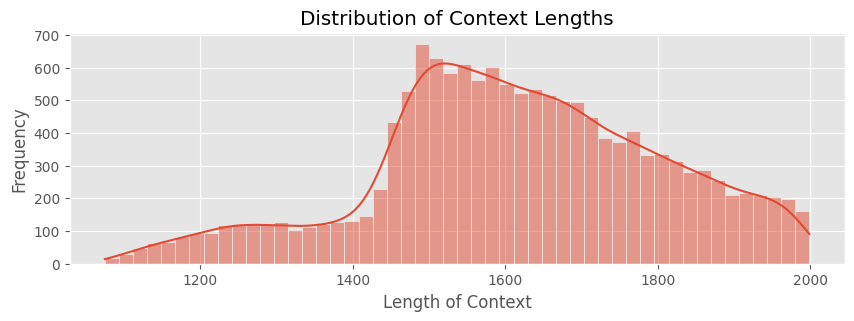

In [11]:
#let's check the data distribution
stats_df=pd.DataFrame()
stats_df['Context_length'] = [len(item) for item in conversation_training_samples['text']]
plt.figure(figsize=(10, 3))
sns.histplot(stats_df['Context_length'], bins=50, kde=True)
plt.title('Distribution of Context Lengths')
plt.xlabel('Length of Context')
plt.ylabel('Frequency')
plt.show()

In [9]:
################################################################################
# LoRA parameters
################################################################################

DEVICE = "cuda:0"

# LoRA attention dimension
lora_r = 16

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha  =lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    target_modules=["q_proj", "k_proj", "v_proj", "up_proj", "down_proj", "o_proj", "gate_proj"],
    bias="none",
    use_rslora = True,
    use_dora=True
    )

model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)

In [16]:
my_output_dir='/content/gdrive/MyDrive/gdrive/cast_ai/model_output'
my_trained_model_dir='/content/gdrive/MyDrive/gdrive/cast_ai/model_trained'

In [11]:
#Define training cycle
training_arguments = SFTConfig(
    output_dir=my_output_dir,
    num_train_epochs=1,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=1,
    per_device_eval_batch_size=8,
    optim="paged_adamw_32bit",
    evaluation_strategy="steps",
    save_steps=0,
    save_strategy="epoch",
    logging_steps=50,
    eval_steps=50,
    learning_rate=4e-4,
    weight_decay=2e-4,
    fp16=False,
    bf16=True,
    label_names=['labels'],
    #max_grad_norm=0.3,
    warmup_ratio = 0.1,#0.03,
    warmup_steps=100,
    lr_scheduler_type="linear",
    report_to="wandb"
)

trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=conversation_training_samples, #ds_train_devtest['train'],
    eval_dataset=conversation_test_samples, #ds_train_devtest['test'],
    dataset_text_field="text",  # need a dummy field
    tokenizer=tokenizer,
    max_seq_length=512,
    )

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length. Will not be supported from version '0.13.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:301: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:329: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will ove

Map:   0%|          | 0/14428 [00:00<?, ? examples/s]

Map:   0%|          | 0/442 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:404: UserWarning: You passed a processing_class with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `processing_class.padding_side = 'right'` to your code.
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: polina-svidovsky. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss
50,1.736800,1.054483
100,1.021900,1.005363
150,1.019400,1.006069
200,1.017400,0.997660
250,1.021500,0.992696
300,1.009400,0.981935
350,1.001000,0.972577
400,0.984200,0.963963
450,0.974900,0.955592
500,0.981500,0.947285


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


TrainOutput(global_step=902, training_loss=1.014369175069348, metrics={'train_runtime': 693.2522, 'train_samples_per_second': 20.812, 'train_steps_per_second': 1.301, 'total_flos': 2.182444680531149e+16, 'train_loss': 1.014369175069348, 'epoch': 1.0})

Note:

1. Monitoring the training/validation loss decrease we can notice that the model didn't perform extensive improvement/learning and needed only slight adaption to generate answers corresponding the instruction.

In [13]:
#free up memory
trainer.model.save_pretrained(my_output_dir)
del model
del trainer
import gc
import torch
torch.cuda.empty_cache()
gc. collect()

In [13]:
#merge adaptor and created a model , if needed.
peft_config = PeftConfig.from_pretrained(my_output_dir)
model = AutoModelForCausalLM.from_pretrained(peft_config.base_model_name_or_path,torch_dtype=torch.bfloat16,low_cpu_mem_usage=True) #,load_in_8bit=True
model = PeftModel.from_pretrained(
            model,
            my_output_dir,
            torch_dtype=torch.float16,
            device_map="auto")
model.eval()
merged_model = model.merge_and_unload()
os.makedirs(my_trained_model_dir, exist_ok=True)
merged_model.save_pretrained(my_trained_model_dir)

In [15]:
#load the trianed model into inference pipeline and test

#model = AutoModelForCausalLM.from_pretrained('/content/gdrive/MyDrive/gdrive/cast_ai/model_trained',torch_dtype=torch.bfloat16,attn_implementation="flash_attention_2",low_cpu_mem_usage=True,device_map="auto") #,load_in_8bit=True
#tokenizer = AutoTokenizer.from_pretrained('/content/gdrive/MyDrive/gdrive/cast_ai/model_trained')
#tokenizer.padding_side = "left"
##tokenizer.pad_token = tokenizer.eos_token
#model.config.pad_token_id = tokenizer.pad_token_id
#model.config.use_cache = False

#model_pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

Device set to use cuda:0


In [51]:
test = load_dataset("rajpurkar/squad", split="validation[:2%]")
test_dataset = test.remove_columns(['id', 'title'])
conversation_validation_samples = test_dataset.map(convert_squad_sample_to_llama_conversation)
conversation_validation_samples

Map:   0%|          | 0/211 [00:00<?, ? examples/s]

Dataset({
    features: ['context', 'question', 'answers', 'text', 'messages', 'answer'],
    num_rows: 211
})

# **LLM performance evaluation:**

 NGRAM metrics: BLEU, ROUGE, METEOR,

 model based (semantic evaluation): BERTScore,BLEURT,BARTScore

 Advanced : LLM as a judge, any model that demonstrated supperior performance over the tested model.
 Can be tackled with more compex task such as judging the quality of the natural langugage generation side of the generated output such as :
 Coherence , Consistency , Fluency, Relevance , etc.

 Notes:

 - ngram metrics fails to catch the semantic side of the texts to be evaluated
 - elaborated summary on LLMs as judges : https://eugeneyan.com/writing/llm-evaluators/#techniques-for-prompting-llm-evaluators , mention how all the metrics that we discussed previously align with human evaluation.
 -

 Plan:

 1. start with BErtScore: in context of our task, we we need a usage of exact terms, with some acceptable deviations , and also don't welcome any additional information (2 text items that contain relevant content mixed with an unusefull one , will get lower score than 2 "clean" items ).
 we will compare the generated answers before training with the gold truth and the generated answers after training with the gold truth.
  - BERTScore's evaluation architecture is designed to evaluate the quality of generated text by comparing it to a reference text. The architecture is built around several key components:

**Token Representation:** BERTScore uses  BERT embeddings.

**Cosine Similarity:** After obtaining the embeddings, BERTScore calculates the cosine similarity between the embeddings of the tokens in the generated text and the reference text. This gives a measure of how semantically similar the generated text is to the reference text .

**Precision, Recall, and F1 Score:** Each token in the reference sentence is matched to the most similar token in the generated sentence, and vice versa. This process is used to calculate the precision, recall, and F1 score, which are measures of the quality of the generated text .

**Importance Weighting (Optional):** This is an optional step in the BERTScore architecture. It assigns different weights to different tokens based on their importance. Tokens that are more likely to be important in the context of the text receive higher weights.


 2. **Evaluate with LLM - LLM as a judge:**
  - in the broad context of natural language generation, items that contain same factual information but refrased , as long as the linguistic structure follows human level standarts - should be scored well on metrics like  Coherence , Consistency , Fluency, Relevance.
  - our case is more focused on metrics like **factuality** : check that the generated text is consistent in terms of facts with the gold truth . and **instruction following** : we need the genertaed answer to be as compact as possible and to contain the same words as in the provided context.
  We can add more like halucinations and safety (what is usually checked when training LLMs) but we will skip it.
  - We can use framework based evaluation/experimet design like with DeepEval , but let's avoid the complexity.
  - Most guidances for using LLM as a judge , recommend first to detail the task , make LLM elaborate the reasoning over the performed steps and only then to provide a score/s. we will follow this approach.

In [15]:
from evaluate import load
# let's use 2 metrics - > BERTScore and exact match
bert_model = "microsoft/deberta-v2-xxlarge-mnli"
bertscore = load("bertscore")
exact_match_metric = load("exact_match")
model_name = "meta-llama/Llama-3.2-1B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'

model = AutoModelForCausalLM.from_pretrained(model_name,torch_dtype=torch.bfloat16,attn_implementation="flash_attention_2",low_cpu_mem_usage=True,device_map="auto") #,load_in_8bit=True

In [ ]:
final_model_path = my_output_dir
model.load_adapter(final_model_path, adapter_name="adapter")

#model.enable_adapters()

model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False

model_pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

def get_bulk_predictions(pipe, samples):
    responses = pipe(samples, max_new_tokens=32, batch_size=len(samples), do_sample=True)
    responses = [i[0]['generated_text'][-1]['content'] for i in responses]
    return responses

def get_base_and_tuned_bulk_predictions(samples):
    bulk_messages = [i[:-1] for i in samples['messages']]
    model.enable_adapters()
    trained_responses = get_bulk_predictions(model_pipe, bulk_messages)
    model.disable_adapters()
    base_responses = get_bulk_predictions(model_pipe, bulk_messages)

    return {"base_prediction": base_responses, "trained_prediction": trained_responses}

In [52]:
# run inference on our test set
conversation_validation_samples = conversation_validation_samples.map(get_base_and_tuned_bulk_predictions, batched=True, batch_size=20)

base_predictions = conversation_validation_samples['base_prediction']
answers = conversation_validation_samples['answer']
base_validation_bert_score = bertscore.compute(predictions=base_predictions, references=answers, lang="en", model_type=bert_model, device="cuda:0")
baseline_exact_match_score = exact_match_metric.compute(predictions=base_predictions, references=answers)
baseline_averages = {
    key: sum(base_validation_bert_score[key])/len(base_validation_bert_score[key]) for key in ['precision', 'recall', 'f1']
}
baseline_averages['exact_match'] = sum(baseline_exact_match_score.values())/len(baseline_exact_match_score.values())


trained_predictions = conversation_validation_samples['trained_prediction']
answers = conversation_validation_samples['answer']
trained_validation_bert_score = bertscore.compute(predictions=trained_predictions, references=answers, lang="en", model_type=bert_model, device="cuda:0")
tuned_exact_match_score = exact_match_metric.compute(predictions=trained_predictions, references=answers)
tuned_averages = {
    key: sum(trained_validation_bert_score[key])/len(trained_validation_bert_score[key]) for key in ['precision', 'recall', 'f1']
}

tuned_averages['exact_match'] = sum(tuned_exact_match_score.values())/len(tuned_exact_match_score.values())

Map:   0%|          | 0/211 [00:00<?, ? examples/s]

In [19]:
print("baseline_averages",baseline_averages)
print("tuned_averages",tuned_averages)

baseline_averages {'precision': 0.5711203302252349, 'recall': 0.7170475150736587, 'f1': 0.6316505625349651, 'exact_match': 0.03317535545023697}
tuned_averages {'precision': 0.7767786942952052, 'recall': 0.8766210644166051, 'f1': 0.817817373439599, 'exact_match': 0.35071090047393366}


 - the precision/recall/f1 score increased after the training by ~ 15% while the
 - Exact match score increased by 30%

Let's make a visual comparison
 - the model predictions before it was trained

In [73]:
conversation_validation_samples['base_prediction'][:10]

['The Denver Broncos represented the AFC at Super Bowl 50.',
 'The NFC champion was the Carolina Panthers.',
 "The Super Bowl 50 took place at Levi's Stadium in Santa Clara, California.",
 'The Denver Broncos won Super Bowl 50.',
 'The league emphasized the "golden anniversary" with various gold-themed initiatives.',
 'The theme of Super Bowl 50 was the "golden anniversary" with various gold-themed initiatives, and the logo featured Arabic numerals 50.',
 'February 7, 2016',
 'The AFC stands for American Football Conference.',
 'The theme of Super Bowl 50 was the "golden anniversary" with various gold-themed initiatives.',
 'The AFC stands for American Football Conference.']

The model predictions after it was trained

In [74]:
conversation_validation_samples['trained_prediction'][:10]

['Denver Broncos',
 'Carolina Panthers',
 "Levi's Stadium in the San Francisco Bay Area at Santa Clara, California.",
 'Denver Broncos',
 'gold',
 'the golden anniversary',
 'February 7, 2016',
 'American Football Conference (AFC)',
 'The golden anniversary with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals, so that the logo',
 'American Football Conference']

- the gold truth answers

In [75]:
conversation_validation_samples['answer'][:10]

['Denver Broncos',
 'Carolina Panthers',
 'Santa Clara, California',
 'Denver Broncos',
 'gold',
 '"golden anniversary"',
 'February 7, 2016',
 'American Football Conference',
 '"golden anniversary"',
 'American Football Conference']

In [11]:
df=pd.DataFrame(conversation_validation_samples)
df[['context','question','answers','base_prediction','trained_prediction']].head()

,context,question,answers,base_prediction,trained_prediction
0,Super Bowl 50 was an American football game to...,Which NFL team represented the AFC at Super Bo...,"{'text': ['Denver Broncos', 'Denver Broncos', ...",The Denver Broncos represented the AFC at Supe...,Denver Broncos
1,Super Bowl 50 was an American football game to...,Which NFL team represented the NFC at Super Bo...,"{'text': ['Carolina Panthers', 'Carolina Panth...",The NFC champion was the Carolina Panthers.,Carolina Panthers
2,Super Bowl 50 was an American football game to...,Where did Super Bowl 50 take place?,"{'text': ['Santa Clara, California', 'Levi's S...",The Super Bowl 50 took place at Levi's Stadium...,Levi's Stadium in the San Francisco Bay Area a...
3,Super Bowl 50 was an American football game to...,Which NFL team won Super Bowl 50?,"{'text': ['Denver Broncos', 'Denver Broncos', ...",The Denver Broncos won Super Bowl 50.,Denver Broncos
4,Super Bowl 50 was an American football game to...,What color was used to emphasize the 50th anni...,"{'text': ['gold', 'gold', 'gold'], 'answer_sta...","The league emphasized the ""golden anniversary""...",gold


**KEY OBSERVATIONS:**
- In most of the cases (~80%) the fact that BERT score wasn't higher is due to the trained model providng more accurate info as comparing to gold truth, like:

Gold answers:       Trained model:
X                   the X
Satnta Clara        Santa Clara, California
8                   eight

in terms of factuality , not a kind of mistakes that reflects on model's inability to "understand" information


- in other ~ 20% of the cases , where more logical understanding is required the trained model was not performin that well. The model struggled with understanding text about sports where more logicaly loaded reasoning needed , like : in context understanding who won , aginst who the game was, how many times the team won (need tu understand the context and calculate) etc.

**LLM as a Judge**

as the most easiest way, we will use OPENAI as a larger model for evaluation.

In [18]:
instruction= """
    You are a helpful assistant tasked with answering users questions from a given CONTEXT. Use the exact words used in context to answer the user's question. Do not add any other information. YOur answer is supposed to be less than 8 words. If you cannot find the answer in the context passage output 'The context does not provide an answer...'
    """
evaluator="""
You are tasked with evaluating two responses based on the provided **CONTEXT** and **INSTRUCTION**. Your goal is to compare **ANSWER_1** and **ANSWER_2** in terms of:

1. **Factual Correctness**: Verify if each answer is factually correct and consistent with the information provided in the **CONTEXT**.
2. **Instruction Following**: Assess how well each answer adheres to the given **INSTRUCTION**.

---

### **Guidelines**:

- **Thorough Analysis**:
  - Begin by carefully reading the **CONTEXT**, **INSTRUCTION**, **QUESTION**, and both answers (**ANSWER_1** and **ANSWER_2**).
  - For each answer:
    - Break down the response into its key components.
    - Analyze each component for factual correctness by cross-referencing with the **CONTEXT**.
    - Explain how each component relates to the **INSTRUCTION** and whether it fulfills the requirements.
    - Reference specific parts of the **CONTEXT** and **INSTRUCTION** to support your analysis.

- **Reasoning and Elaboration**:
  - Provide detailed reasoning for your evaluation of each answer.
  - Highlight any factual inaccuracies, inconsistencies, or deviations from the **INSTRUCTION**.
  - Ensure that your reasoning is logical and clear.

- **Evaluation Summary**:
  - After analyzing both answers, provide a summary for each.
  - Assign scores for each answer on a scale from 1 to 10, where 1 is the lowest and 10 is the highest.
  - Present the final scores in the following JSON format:

```json
{{ "answer_num": "", "factuality": "", "instruction_following": "" }}
```

---

### **Instructions**:

- Use the placeholders **{context}**, **{instruction}**, **{question}**, **{answer_1}**, and **{answer_2}** as provided.
- Evaluate **ANSWER_1** and **ANSWER_2** separately following the guidelines above.
- Focus solely on the information given without introducing external knowledge.
- Be objective and unbiased in your assessment.

---

**Example Structure**:

1. **Evaluation of ANSWER_1**:
   - *Analysis and Reasoning*:
     - [Provide detailed analysis here.]
   - *Summary*:
     - [Summarize the findings.]

2. **Evaluation of ANSWER_2**:
   - *Analysis and Reasoning*:
     - [Provide detailed analysis here.]
   - *Summary*:
     - [Summarize the findings.]

3. **Final Scores**:

```json
[
{{ "answer_num": "1", "factuality": "", "instruction_following": "" }},
  {{ "answer_num": "2", "factuality": "", "instruction_following": "" }}
]
```
"""

In [21]:
import os
os.environ['OPENAI_API_KEY']="your_key"
from openai import OpenAI
client = OpenAI()

def process(input,instruction):
    messages=[
            {
              "role": "system",
              "content": [
                {
                  "type": "text",
                  "text":instruction
                }
              ],
            },
            {
              "role": "user",
              "content": [
                {
                  "type": "text",
                  "text":input
                }
              ],
            }
          ]
    response = client.chat.completions.create(
      model="gpt-4o",
      messages=messages
        )
    return response.choices[0].message.content

In [103]:
import json
evaluations=[]
for  item in conversation_validation_samples:
        input="""
 **CONTEXT**:
 {context}

 **INSTRUCTION**:
 {instruction}

 **QUESTION**:
 {question}

 **ANSWER_1**:
 {answer_1}

 **ANSWER_2**:
 {answer_2}""".format(context=item['context'],instruction=instruction,question=item['question'],answer_1=item['base_prediction'],answer_2=item['trained_prediction'])
        response=process(input,evaluator)
        evaluations.append(json.loads(response.replace('\n','').split('json')[1].split("```")[0].split("'''")[0].replace('\n','').strip()))

In [44]:
print("NOT trained: factuality: ",sum([int(item[0]['factuality']) for item in evaluations])/len(evaluations))
print("NOT trained: instruction following: ",sum([int(item[0]['instruction_following']) for item in evaluations])/len(evaluations))
print("trained: factuality: ",sum([int(item[1]['factuality']) for item in evaluations])/len(evaluations))
print("trained: instruction following: ",sum([int(item[1]['instruction_following']) for item in evaluations])/len(evaluations) )

NOT trained: factuality:  7.582417582417582
NOT trained: instruction following:  6.241758241758242
trained: factuality:  8.538461538461538
trained: instruction following:  7.373626373626373


- Both the factuality (and as a consequence a context understanding) and the instruction following improved in the trained model.
- The ~20% fail on context understanding that we observed, refelects in the factuality score.
- From the more compact answers provided by the trained model we can observe the improvement in instruction following.

though berscore technically represent different kind of metric , however logically it has corellation both with factuallity and instruction following in our case (wording in generated answer (-> fact described) that will deviate from the gold truth will reduce the score).
- BertScores before training of ~ 6-7 (0.6-0.7) , and the improved scores after training ~8 (0.8) correlate both with our observations and with LLM-as-a-judge.
- Assuming that LLM-as-a-judge was trained on human evaluations , the last observation confirms the fact that BerScore was found to have a good correlation with human evaluation.

**Conclusions:**

 - we definitelly could eperiment more with model training hyperparameters/ dataset organization and model size to achieve better performance.
 - We could examine larger model since there is a good chance that more complex logical pattern understanding is limited by the size of chosen model.
 - In context of the given task with given type of generated text BERTScore and exact match are good metrics.
 - LLM as a judge scores correlate with BERTScore ealuation.